### 1. Memuat Data

Langkah pertama memuat dataset dari file CSV ke dalam Pandas DataFrame untuk mulai memeriksa dan memanipulasi data.

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Online Retail Data Set.csv', encoding='latin1')

# Menampilkan 5 baris pertama data
display(df.head())

Mounted at /content/drive


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### 2. Pemeriksaan Awal dan Tipe Data

Sebelum membersihkan, perlu memahami struktur data, jumlah baris dan kolom, tipe data masing-masing kolom, dan keberadaan nilai yang hilang (`null`/`NaN`).

In [2]:
# Menampilkan informasi umum tentang DataFrame
print('Informasi DataFrame:')
df.info()

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
# Memeriksa jumlah nilai yang hilang per kolom
print('\nJumlah nilai hilang per kolom:')
display(df.isnull().sum())


Jumlah nilai hilang per kolom:


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


### 3. Penanganan Nilai Hilang

Dari pemeriksaan awal, terlihat kolom `Description` dan `CustomerID` memiliki nilai yang hilang. Karena `CustomerID` sangat krusial untuk analisis RFM, baris-baris dengan `CustomerID` yang hilang dibuang. Untuk `Description`, dibiarkan karena tidak digunakan dalam perhitungan RFM.

In [4]:
# Menghapus baris dengan CustomerID yang kosong karena tidak dapat digunakan untuk segmentasi pelanggan
df_cleaned = df.dropna(subset=['CustomerID'])

# Mengubah tipe data CustomerID menjadi integer
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

print('Jumlah baris setelah menghapus CustomerID yang hilang:', len(df_cleaned))
print('\nMemeriksa kembali jumlah nilai hilang:')
display(df_cleaned.isnull().sum())

Jumlah baris setelah menghapus CustomerID yang hilang: 406829

Memeriksa kembali jumlah nilai hilang:


/tmp/ipython-input-2834654516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


### 4. Membersihkan Data Kuantitas dan Harga

Kolom `Quantity` dan `UnitPrice` harus bernilai positif untuk transaksi penjualan yang valid. Nilai negatif pada `Quantity` biasanya menunjukkan retur barang, yang tidak relevan untuk analisis RFM ini. serta harga nol atau negatif (`UnitPrice`) tidak masuk akal untuk transaksi penjualan.

In [5]:
# Filter transaksi yang Kuantitasnya kurang dari atau sama dengan 0
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]

# Filter transaksi di mana UnitPrice kurang dari atau sama dengan 0
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

print('Jumlah baris setelah membersihkan Quantity dan UnitPrice:', len(df_cleaned))
display(df_cleaned.head())

Jumlah baris setelah membersihkan Quantity dan UnitPrice: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850,United Kingdom


### 5. Mengubah Tipe Data InvoiceDate

Kolom `InvoiceDate` saat ini bertipe `object` (string). Untuk melakukan perhitungan terkait tanggal (kayak `Recency`), perlu mengubahnya menjadi tipe data `datetime`.

In [6]:
# Mengubah 'InvoiceDate' menjadi tipe datetime dengan format yang betul
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'], format='%d-%m-%Y %H:%M')

print('Tipe data InvoiceDate setelah konversi:')
display(df_cleaned.info())

Tipe data InvoiceDate setelah konversi:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB


None

## 2. Menghitung Nilai RFM

Untuk analisis RFM, perlu menghitung tiga metrik utama untuk setiap `CustomerID`:

*   **Recency (R):** Berapa hari sejak pembelian terakhir pelanggan. Semakin kecil nilainya, semakin baru interaksi pelanggan.
*   **Frequency (F):** Berapa kali pelanggan membeli dalam periode waktu tertentu. Semakin besar nilainya, semakin sering pelanggan berbelanja.
*   **Monetary (M):** Total uang yang dihabiskan pelanggan. Semakin besar nilainya, semakin banyak uang yang dihabiskan pelanggan.

### 2.1 Menghitung Total Belanja (TotalPrice)

Sebelum menghitung M, kami perlu membuat kolom `TotalPrice` yang merupakan hasil kali `Quantity` dan `UnitPrice` untuk setiap baris transaksi.

In [7]:
# Menghitung TotalPrice untuk setiap transaksi
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
display(df_cleaned.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


### 2.2 Menentukan Tanggal Referensi

Untuk menghitung Recency, diperlukan tanggal referensi. Tanggal ini biasanya satu hari setelah tanggal transaksi terakhir dalam dataset untuk memastikan semua nilai Recency positif cmiiw.

In [8]:
# Menentukan tanggal terakhir transaksi dalam dataset
latest_date = df_cleaned['InvoiceDate'].max()

# Menentukan tanggal referensi (satu hari setelah tanggal transaksi terakhir)
reference_date = latest_date + pd.Timedelta(days=1)

print(f"Tanggal transaksi terakhir dalam dataset: {latest_date}")
print(f"Tanggal referensi untuk perhitungan Recency: {reference_date}")

Tanggal transaksi terakhir dalam dataset: 2011-12-09 12:50:00
Tanggal referensi untuk perhitungan Recency: 2011-12-10 12:50:00


### 2.3 Menghitung Nilai R, F, dan M

Sekarang kami mengelompokkan data berdasarkan `CustomerID` dan menghitung Recency, Frequency, dan Monetary.

In [9]:
# Menghitung RFM
rfm_df = df_cleaned.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (reference_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

# Menampilkan 5 baris pertama dari DataFrame RFM
print('DataFrame RFM:')
display(rfm_df.head())

DataFrame RFM:


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


Data RFM telah berhasil dihitung. sekarang kami memiliki gambaran awal tentang perilaku pembelian setiap pelanggan. selanjutnya **Normalisasi data**.

## 3. Normalisasi Data

Metrik RFM (Recency, Frequency, Monetary) memiliki rentang nilai yang bervariasi. Misalnya, Recency bisa dalam hitungan hari (0-365+), Frequency dalam hitungan transaksi (1-puluhan), dan Monetary dalam jumlah uang (puluhan hingga ribuan). Algoritma _clustering_ seperti K-Means sensitif terhadap skala data. karena itu, penting untuk kami menormalisasi metrik RFM agar setiap fitur berkontribusi secara proporsional dalam proses _clustering_.

Menggunakan _StandardScaler_ dari `sklearn.preprocessing` yang menstandardisasi fitur dengan menghapus rata-rata dan menskalakan ke varians unit. Ini harusnya menghasilkan data dengan rata-rata 0 dan standar deviasi 1.

In [10]:
from sklearn.preprocessing import StandardScaler

# Memilih kolom RFM untuk normalisasi
rfm_features = ['Recency', 'Frequency', 'Monetary']
rfm_data = rfm_df[rfm_features]

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Melakukan normalisasi pada data RFM
rfm_scaled = scaler.fit_transform(rfm_data)

# Membuat DataFrame baru dari data yang telah dinormalisasi
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_features, index=rfm_df.index)

print('5 baris pertama data RFM setelah normalisasi:')
display(rfm_scaled_df.head())

print('\nStatistik deskriptif data RFM setelah normalisasi:')
display(rfm_scaled_df.describe())

5 baris pertama data RFM setelah normalisasi:


,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.358668
1,-0.905340,0.354417,0.250966
2,-0.175360,-0.035340,-0.028596
3,-0.735345,-0.425097,-0.033012
4,2.174578,-0.425097,-0.191347



Statistik deskriptif data RFM setelah normalisasi:


,Recency,Frequency,Monetary
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,2.702618e-17,1.801745e-17,1.801745e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.153401e-01,-4.250965e-01,-2.281344e-01
25%,-7.453445e-01,-4.250965e-01,-1.943495e-01
50%,-4.153533e-01,-2.951776e-01,-1.535104e-01
75%,4.946227e-01,9.457903e-02,-4.367134e-02
max,2.814561e+00,2.659803e+01,3.094634e+01


Data RFM berhasil dinormalisasi. nilai-nilai sekarang terpusat di sekitar 0 dengan standar deviasi 1, yang merupakan kondisi ideal untuk algoritma _clustering_. selanjutnya **Menentukan jumlah cluster optimal**.

## 4. Menentukan Jumlah Cluster Optimal

Menentukan jumlah _cluster_ yang optimal (nilai K) adalah langkah krusial dalam K-Means _clustering_. Jika K terlalu kecil, _cluster_ kemungkinan terlalu luas dan tidak spesifik. Jika K terlalu besar, _cluster_ kemungkinan terlalu terfragmentasi dan kurang bermakna. jadi kami menggunakan dua metode populer:

1.  **Metode Elbow**: Mencari titik di mana penurunan _inertia_ (jumlah kuadrat jarak antara setiap titik data ke centroid cluster nya) mulai melambat, membentuk 'siku'.
2.  **Analisis Siluet**: Mengukur seberapa mirip suatu objek dengan cluster nya sendiri (kohesi) dibandingkan dengan cluster lain (separasi).

### 4.1 Metode Elbow

menghitung _inertia_ untuk berbagai nilai K dan memplotnya untuk mencari 'siku'.

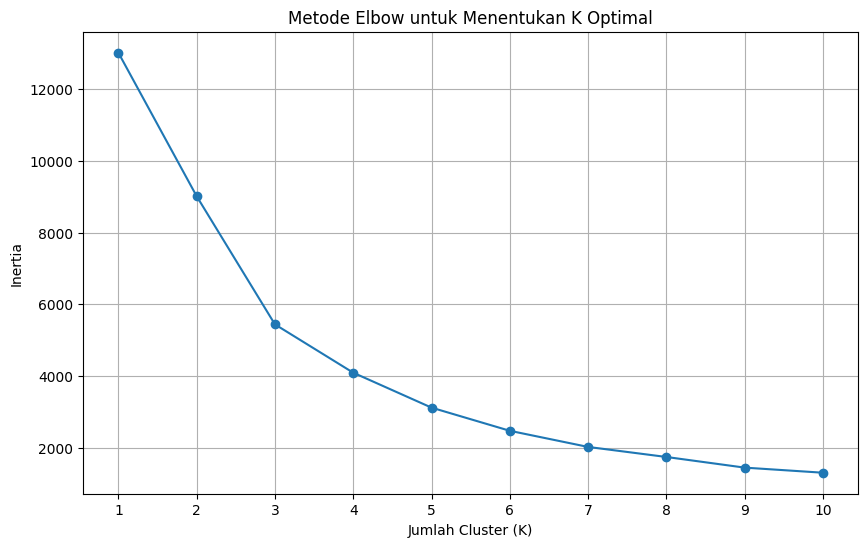

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# List untuk menyimpan nilai inertia
inertia_values = []

# Menguji K dari 1 hingga 10
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init untuk mengatasi inisialisasi awal
    kmeans.fit(rfm_scaled_df)
    inertia_values.append(kmeans.inertia_)

# Memplot metode Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Metode Elbow untuk Menentukan K Optimal')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Dari plot Metode Elbow, mencari titik 'siku' di mana penurunan _inertia_ tidak lagi signifikan. menunjukkan jumlah *cluster* yang baik di mana penambahan *cluster* lagi tidak banyak memberikan informasi baru.

### 4.2 Analisis Siluet

Selanjutnya, menggunakan silhouette score untuk mengkonfirmasi jumlah *cluster* optimal. Silhouette score berkisar dari -1 hingga 1, di mana nilai yang lebih tinggi menunjukkan *cluster* yang lebih padat dan terpisah dengan baik.

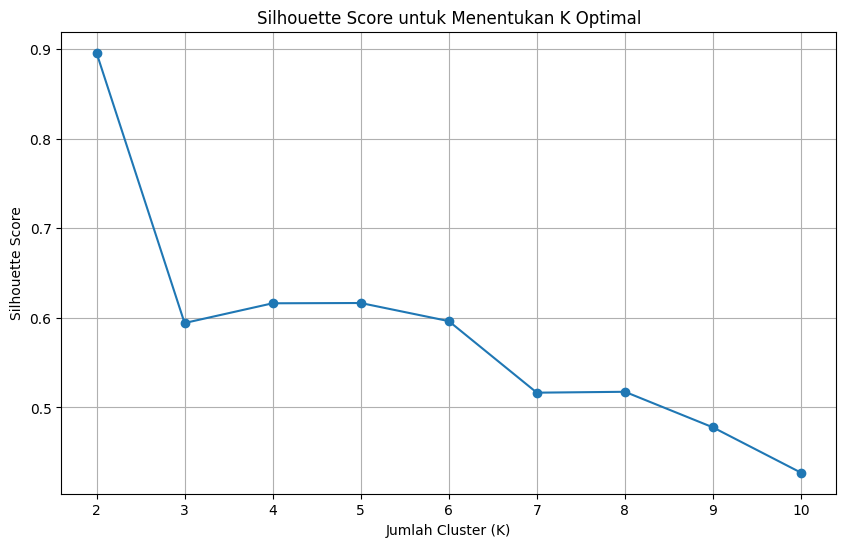

In [12]:
from sklearn.metrics import silhouette_score

# List untuk menyimpan nilai silhouette score
silhouette_scores = []

# Menguji K dari 2 hingga 10 (Silhouette score tidak terdefinisi untuk K=1)
k_range_silhouette = range(2, 11)

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Memplot hasil silhouette score
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o')
plt.title('Silhouette Score untuk Menentukan K Optimal')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()

Dari plot _Silhouette Score_, mencari nilai K yang menghasilkan skor siluet tertinggi, karena ini mengindikasikan *cluster* yang paling optimal secara internal padat dan terpisah satu sama lain.

Dengan mempertimbangkan kedua metode ini, kami bisa membuat keputusan yang lebih berinformasi mengenai jumlah _cluster_ yang akan digunakan untuk K-Means. Setelah menganalisis kedua plot tersebut, dapat menentukan K optimal.

## 5. Menerapkan K-Means Clustering

Setelah menentukan jumlah _cluster_ optimal (akan menggunakan K=4), langkah selanjutnya adalah menerapkan algoritma K-Means pada data RFM yang telah dinormalisasi (`rfm_scaled_df`). Hasil dari K-Means berupa label _cluster_ untuk setiap pelanggan, kemudian ditambahkan kembali ke DataFrame RFM asli (`rfm_df`).

In [13]:
from sklearn.cluster import KMeans

# Memilih jumlah cluster optimal (berdasarkan analisis Elbow dan Silhouette)
k_optimal = 4

# Menerapkan K-Means clustering
kmeans_model = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_model.fit(rfm_scaled_df)

# Menambahkan label cluster ke DataFrame RFM asli
rfm_df['Cluster'] = kmeans_model.labels_

print(f'K-Means clustering dengan {k_optimal} cluster telah berhasil diterapkan.')
print('\nDistribusi pelanggan di setiap cluster:')
display(rfm_df['Cluster'].value_counts())

K-Means clustering dengan 4 cluster telah berhasil diterapkan.

Distribusi pelanggan di setiap cluster:


,count
Cluster,
0,3054
1,1067
3,204
2,13


In [14]:
print('\n5 baris pertama DataFrame RFM dengan label cluster:')
display(rfm_df.head())


5 baris pertama DataFrame RFM dengan label cluster:


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,3
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,0
3,12349,19,1,1757.55,0
4,12350,310,1,334.40,1


K-Means Clustering telah berhasil diterapkan, dan setiap pelanggan kini memiliki label *cluster*. selanjutnya adalah **Visualisasi hasil** dan **Interpretasi dan insight bisnis**.

## 6. Visualisasi Hasil Clustering

Setelah menerapkan K-Means dan mendapatkan label _cluster_ untuk setiap pelanggan, langkah selanjutnya adalah memvisualisasikan hasilnya. Visualisasi akan membantu kami memahami karakteristik dari setiap _cluster_ dan bagaimana mereka berbeda satu sama lain berdasarkan metrik RFM.

mulai dengan menganalisis statistik deskriptif (rata-rata) dari Recency, Frequency, dan Monetary untuk setiap _cluster_. Kemudian membuat plot sebar (scatter plot) untuk memvisualisasikan _cluster_ dalam ruang RFM.

### 6.1 Analisis Rata-rata RFM per Cluster

Menghitung nilai rata-rata R, F, dan M untuk setiap _cluster_ memberikan ringkasan yang jelas tentang perilaku pelanggan dalam setiap segmen.

In [15]:
# Menghitung rata-rata Recency, Frequency, dan Monetary untuk setiap cluster
rfm_cluster_agg = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

print('Rata-rata RFM per Cluster:')
display(rfm_cluster_agg)

Rata-rata RFM per Cluster:


,Cluster,Recency,Frequency,Monetary
0,0,43.702685,3.682711,1359.049284
1,1,248.075914,1.552015,480.617480
2,2,7.384615,82.538462,127338.313846
3,3,15.500000,22.333333,12709.090490


### 6.2 Visualisasi Scatter Plot 2D

Untuk memvisualisasikan _cluster_ dalam dua dimensi yaitu membuat plot sebar pasangan fitur RFM (`Recency` vs `Frequency`, `Recency` vs `Monetary`, dan `Frequency` vs `Monetary`), setiap _cluster_ diwakili oleh warna yang berbeda.

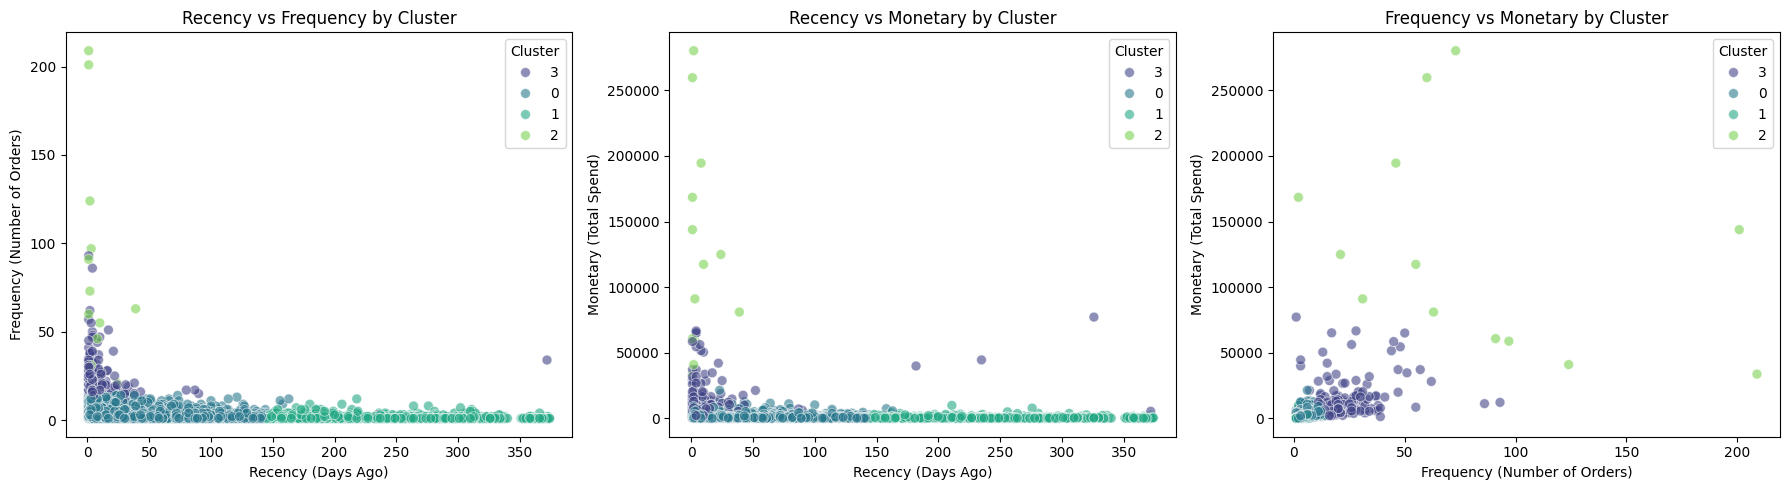

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

rfm_df_viz = rfm_df.copy()
rfm_df_viz['Cluster'] = rfm_df_viz['Cluster'].astype(str)

plt.figure(figsize=(18, 5))

# Plot Recency vs Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df_viz, palette='viridis', s=50, alpha=0.6)
plt.title('Recency vs Frequency by Cluster')
plt.xlabel('Recency (Days Ago)')
plt.ylabel('Frequency (Number of Orders)')
plt.legend(title='Cluster')

# Plot Recency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_df_viz, palette='viridis', s=50, alpha=0.6)
plt.title('Recency vs Monetary by Cluster')
plt.xlabel('Recency (Days Ago)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')

# Plot Frequency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm_df_viz, palette='viridis', s=50, alpha=0.6)
plt.title('Frequency vs Monetary by Cluster')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

### 6.3 Visualisasi Scatter Plot 3D

Untuk mendapatkan gambaran yang lebih komprehensif, kami memvisualisasikan ketiga fitur RFM secara bersamaan dalam plot 3D.

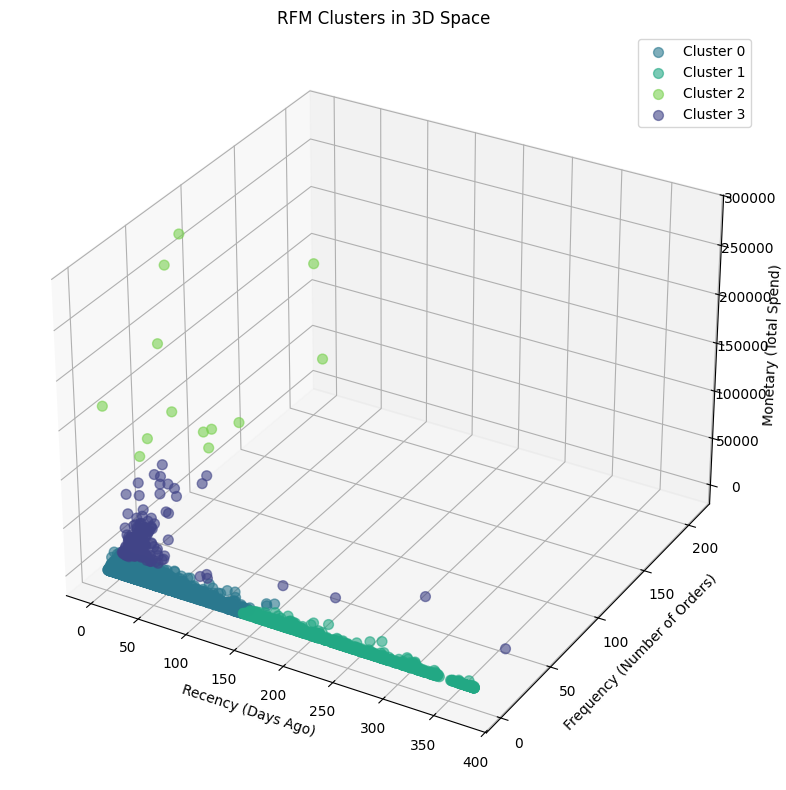

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

palette = sns.color_palette('viridis', n_colors=len(rfm_df_viz['Cluster'].unique()))
cluster_colors = {str(c): palette[i] for i, c in enumerate(rfm_df_viz['Cluster'].unique())}

for cluster_id in sorted(rfm_df_viz['Cluster'].unique()):
    subset = rfm_df_viz[rfm_df_viz['Cluster'] == cluster_id]
    ax.scatter(subset['Recency'], subset['Frequency'], subset['Monetary'],
               color=cluster_colors[cluster_id], label=f'Cluster {cluster_id}', s=50, alpha=0.6)

ax.set_xlabel('Recency (Days Ago)')
ax.set_ylabel('Frequency (Number of Orders)')
ax.set_zlabel('Monetary (Total Spend)')
ax.set_title('RFM Clusters in 3D Space')
ax.legend()
plt.tight_layout()
plt.show()

Visualisasi terlihat bagaimana pelanggan terdistribusi di setiap *cluster* berdasarkan metrik RFM mereka. selanjutnya **Interpretasi dan _insight_ bisnis** dari *cluster-cluster* ini.

## 7. Interpretasi dan _Insight_ Bisnis

Setelah berhasil kami mengelompokkan pelanggan ke dalam *cluster* berdasarkan metrik RFM, selanjutnya menginterpretasikan karakteristik setiap *cluster* dan menerjemahkannya ke dalam _insight_ bisnis yang bisa ditindaklanjuti. dengan memahami profil setiap segmen, mengembangkan strategi pemasaran yang lebih personal dan efektif.

### 7.1 Analisis Profil Setiap Cluster

tinjau kembali rata-rata RFM untuk setiap *cluster* dan memberikan nama deskriptif untuk masing-masing segmen:

In [18]:
# untuk menampilkan rata-rata RFM per cluster lagi untuk referensi
display(rfm_cluster_agg)

# Memetakan profil berdasarkan rata-rata RFM
# Recency rendah = pelanggan baru/loyal, Recency tinggi = pelanggan lama/churn
# Frequency tinggi = sering beli, Monetary tinggi = banyak belanja

cluster_profile = {
    0: 'Loyal Customers',
    1: 'At-Risk',
    2: 'Best Spenders',
    3: 'Big Spenders'
}

rfm_cluster_agg['Cluster_Name'] = rfm_cluster_agg['Cluster'].map(cluster_profile)

print('\nProfil Cluster berdasarkan Rata-rata RFM (diurutkan berdasarkan Recency terendah):')
display(rfm_cluster_agg[['Cluster_Name', 'Recency', 'Frequency', 'Monetary']].sort_values(by='Recency'))

,Cluster,Recency,Frequency,Monetary
0,0,43.702685,3.682711,1359.049284
1,1,248.075914,1.552015,480.617480
2,2,7.384615,82.538462,127338.313846
3,3,15.500000,22.333333,12709.090490



Profil Cluster berdasarkan Rata-rata RFM (diurutkan berdasarkan Recency terendah):


,Cluster_Name,Recency,Frequency,Monetary
2,Best Spenders,7.384615,82.538462,127338.313846
3,Big Spenders,15.500000,22.333333,12709.090490
0,Loyal Customers,43.702685,3.682711,1359.049284
1,At-Risk,248.075914,1.552015,480.617480


### 7.2 _Insight_ Bisnis dan Rekomendasi Strategi Pemasaran

Berdasarkan profil di atas, berikut adalah _insight_ bisnis dan rekomendasi strategi pemasaran yang dapat diterapkan untuk setiap segmen berdasarkan pemahaman kami:

#### **Cluster 2: Best Spenders**
*   **Karakteristik:** (Recency sangat rendah, Frequency sangat tinggi, Monetary sangat tinggi)
    *   Pelanggan paling berharga, baru saja membeli, sering membeli, dan menghabiskan uang paling banyak. inti dari basis pelanggan.
*   **_Insight_ Bisnis:** Mereka adalah aset terbesar perusahaan. Retensi mereka adalah prioritas utama.
*   **Rekomendasi Strategi:**
    *   **Program Loyalitas Eksklusif:** Tawarkan *reward* premium, akses awal ke produk baru, atau diskon khusus.
    *   **Komunikasi Personalisasi:** Jaga komunikasi yang relevan, mintalah umpan balik, libatkan mereka dalam pengembangan produk.
    *   **Layanan Pelanggan Prioritas:** Berikan dukungan prioritas dan personal.
    *   **Upselling/Cross-selling:** Tawarkan produk pelengkap atau versi premium yang relevan.

#### **Cluster 3: Big Spenders**
*   **Karakteristik:** (Recency rendah, Frequency tinggi, Monetary sangat tinggi)
    *   Pelanggan yang baru saja membeli, sering membeli, dan menghabiskan banyak uang, tetapi mungkin belum setinggi 'Best Spenders'. Mereka memiliki potensi besar untuk menjadi pelanggan terbaik.
*   **_Insight_ Bisnis:** Segmen yang sangat menjanjikan. Dorong mereka untuk meningkatkan frekuensi atau monetary lebih lanjut.
*   **Rekomendasi Strategi:**
    *   **Promosi Khusus:** Tawarkan diskon bertingkat atau *bundle* produk yang menarik untuk mendorong pembelian lebih lanjut.
    *   **_Personalized Recommendations_:** Berikan rekomendasi produk berdasarkan riwayat pembelian mereka untuk meningkatkan *Monetary*.
    *   **_Nurturing Campaign_:** Libatkan mereka dengan konten yang relevan dan tunjukkan apresiasi.

#### **Cluster 0: Loyal Customers**
*   **Karakteristik:** (Recency sedang, Frequency sedang, Monetary sedang)
    *   Pelanggan yang cukup sering membeli dan menghabiskan jumlah yang lumayan, namun mungkin tidak seaktif atau sebanyak'Best Spenders'.
*   **_Insight_ Bisnis:** Mereka adalah basis pelanggan yang stabil. Pertahankan mereka agar tidak beralih ke pesaing dan dorong peningkatan nilai pembelian.
*   **Rekomendasi Strategi:**
    *   **Program Loyalitas Standar:** Berikan insentif reguler untuk pembelian berulang.
    *   **Komunikasi Reguler:** Kirim *newsletter* dengan penawaran produk baru atau diskon musiman.
    *   **Dorong _Upselling_:** Berikan insentif kecil untuk mendorong mereka mencoba produk dengan nilai lebih tinggi atau membeli lebih banyak item.

#### **Cluster 1: At-Risk**
*   **Karakteristik:** (Recency sangat tinggi, Frequency rendah, Monetary rendah)
    *   Pelanggan yang sudah lama tidak membeli, jarang membeli, dan menghabiskan sedikit uang. Mereka berisiko tinggi untuk *churn* atau bahkan sudah tidak aktif.
*   **_Insight_ Bisnis:** Segmen ini membutuhkan perhatian segera untuk mencegah *churn* atau mengaktifkan kembali.
*   **Rekomendasi Strategi:**
    *   **Kampanye Reaktivasi:** Tawarkan diskon besar atau penawaran misalnya *"we miss you"* yang menarik untuk mendorong pembelian pertama atau kembali.
    *   **Survei Umpan Balik:** Coba pahami alasan mengapa mereka tidak lagi aktif.
    *   **Fokus pada Nilai:** Soroti nilai atau manfaat unik dari produk/layanan yang mungkin telah mereka lupakan.
    *   **Penawaran Produk Terbaru:** Berikan informasi tentang produk atau fitur baru yang mungkin menarik minat mereka kembali.

### 7.3 Kesimpulan

Segmentasi pelanggan menggunakan RFM dan K-Means Clustering telah memberikan pemahaman yang jelas tentang berbagai jenis pelanggan yang dimiliki. Dengan menerapkan strategi pemasaran yang disesuaikan untuk setiap segmen, perusahaan dapat mengalokasikan sumber daya secara lebih efisien, meningkatkan retensi pelanggan, dan memaksimalkan nilai seumur hidup pelanggan (CLV). selanjutnya adalah mengimplementasikan strategi ini dan memantau dampaknya secara berkelanjutan.

### 7.3.1 Visualisasi Tambahan Profil Cluster

Untuk lebih memperjelas perbedaan antar *cluster* yaitu dengan membuat *heatmap* dari rata-rata RFM dan *bar chart* distribusi pelanggan per *cluster*.

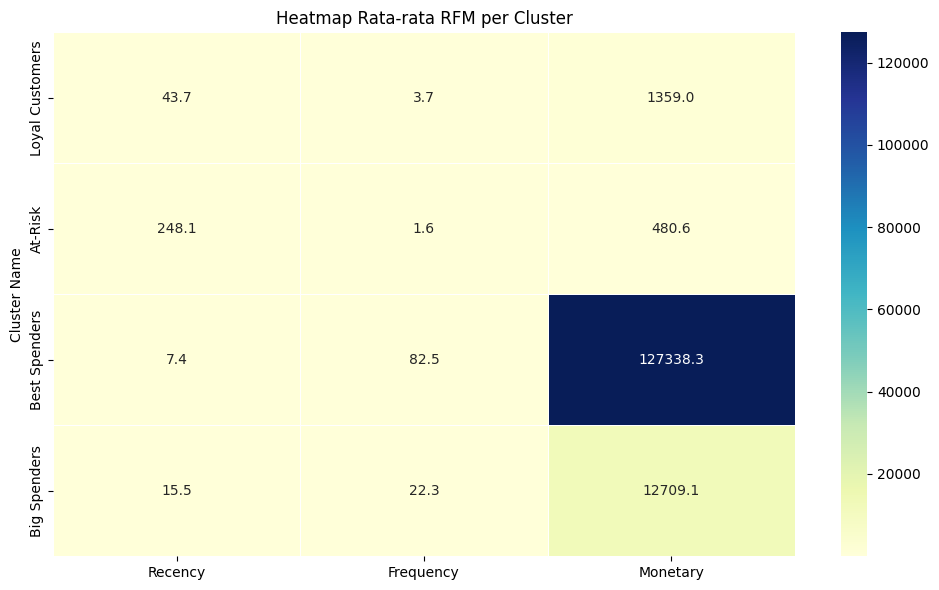

/tmp/ipython-input-4031398321.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_labels.values, y=cluster_counts.values, palette='viridis')


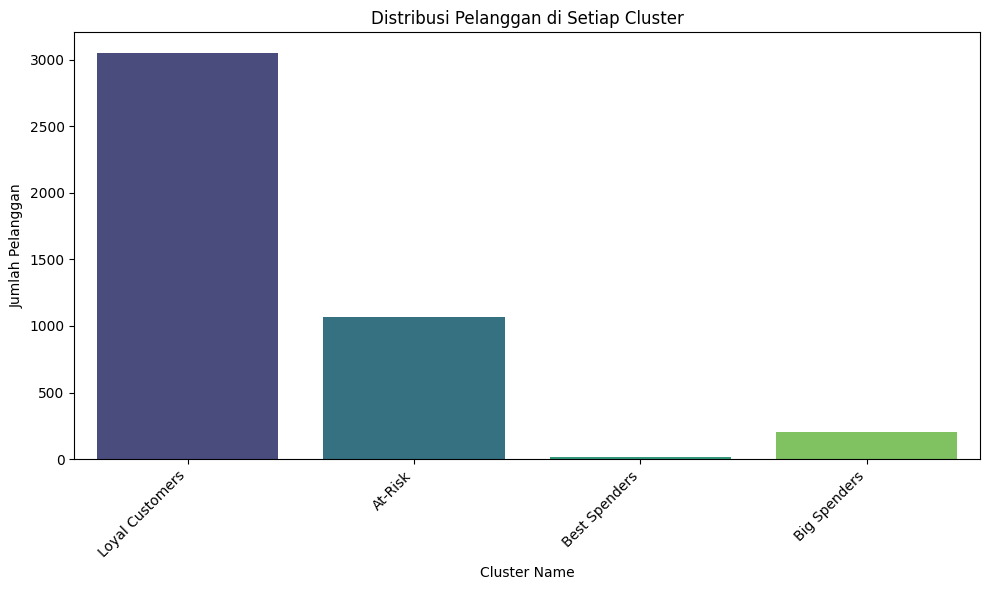

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Heatmap Rata-rata RFM per Cluster ---
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_cluster_agg.set_index('Cluster_Name')[['Recency', 'Frequency', 'Monetary']],
            annot=True, cmap='YlGnBu', fmt='.1f', linewidths=.5)
plt.title('Heatmap Rata-rata RFM per Cluster')
plt.ylabel('Cluster Name')
plt.tight_layout()
plt.show()

# --- Bar Chart Distribusi Pelanggan per Cluster ---
cluster_counts = rfm_df['Cluster'].value_counts().sort_index()
cluster_labels = rfm_cluster_agg.set_index('Cluster').loc[cluster_counts.index, 'Cluster_Name']

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_labels.values, y=cluster_counts.values, palette='viridis')
plt.title('Distribusi Pelanggan di Setiap Cluster')
plt.xlabel('Cluster Name')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 7.3.2 Validasi Cluster Lanjutan (ANOVA)

Untuk memastikan lagi bahwa perbedaan rata-rata metrik RFM antar *cluster* adalah signifikan secara statistik, kami melakukan uji ANOVA (Analysis of Variance) untuk membantu memvalidasi bahwa *cluster* yang dibentuk memang memiliki karakteristik yang berbeda secara bermakna.

In [20]:
from scipy.stats import f_oneway

print('ANOVA Test untuk Metrik RFM antar Cluster:')

# Uji ANOVA untuk Recency
recency_clusters = [rfm_df['Recency'][rfm_df['Cluster'] == i] for i in rfm_df['Cluster'].unique()]
f_stat_r, p_value_r = f_oneway(*recency_clusters)
print(f"Recency: F-statistic={f_stat_r:.2f}, p-value={p_value_r:.3e}")

# Uji ANOVA untuk Frequency
frequency_clusters = [rfm_df['Frequency'][rfm_df['Cluster'] == i] for i in rfm_df['Cluster'].unique()]
f_stat_f, p_value_f = f_oneway(*frequency_clusters)
print(f"Frequency: F-statistic={f_stat_f:.2f}, p-value={p_value_f:.3e}")

# Uji ANOVA untuk Monetary
monetary_clusters = [rfm_df['Monetary'][rfm_df['Cluster'] == i] for i in rfm_df['Cluster'].unique()]
f_stat_m, p_value_m = f_oneway(*monetary_clusters)
print(f"Monetary: F-statistic={f_stat_m:.2f}, p-value={p_value_m:.3e}")

print('\nInterpretasi:')
print('Jika p-value sangat kecil (misal < 0.05), maka terdapat perbedaan rata-rata yang signifikan secara statistik antar cluster untuk metrik tersebut.')

ANOVA Test untuk Metrik RFM antar Cluster:
Recency: F-statistic=5533.76, p-value=0.000e+00
Frequency: F-statistic=2200.00, p-value=0.000e+00
Monetary: F-statistic=2805.25, p-value=0.000e+00

Interpretasi:
Jika p-value sangat kecil (misal < 0.05), maka terdapat perbedaan rata-rata yang signifikan secara statistik antar cluster untuk metrik tersebut.


Ringkasan Akhir

Proyek ini bertujuan untuk mengidentifikasi segmen pelanggan yang bermakna dari Online Retail Dataset (Kaggle – Tata) melalui analisis RFM (Recency, Frequency, Monetary) dan K-Means Clustering untuk mendukung strategi pemasaran yang lebih personal dan efisien.

Tahapan Utama yang Telah Dilakukan:

1. Pemuatan dan Pembersihan Data: Data transaksi awal dimuat, nilai hilang pada CustomerID ditangani, transaksi tidak valid (Quantity/UnitPrice <= 0) dihapus, dan kolom InvoiceDate dikonversi ke format datetime yang benar untuk memastikan kualitas data untuk analisis.
2. Perhitungan RFM: Metrik Recency, Frequency, dan Monetary dihitung untuk setiap pelanggan. TotalPrice transaksi dihitung, dan tanggal referensi ditentukan untuk akurasi Recency.
3. Normalisasi Data: Data RFM dinormalisasi menggunakan StandardScaler untuk menghilangkan bias skala, menjadikan data siap untuk algoritma clustering.
4. Penentuan Jumlah Cluster Optimal: Metode Elbow dan Analisis Siluet digunakan untuk mengevaluasi berbagai jumlah cluster. Hasilnya mengindikasikan K=4 sebagai jumlah cluster optimal yang menyeimbangkan inertia dan silhouette score.
5. Penerapan K-Means Clustering: Algoritma K-Means diterapkan pada data RFM yang dinormalisasi dengan K=4. Label cluster kemudian ditambahkan kembali ke DataFrame pelanggan asli.
6. Visualisasi Hasil Clustering: Berbagai visualisasi, termasuk rata-rata RFM per cluster, scatter plot 2D, scatter plot 3D, heatmap, dan bar chart distribusi pelanggan, dibuat untuk memahami profil dan sebaran setiap segmen.
7. Interpretasi dan Insight Bisnis: Empat segmen pelanggan yang berbeda berhasil diidentifikasi dan diberi nama berdasarkan karakteristik RFM mereka:
 * Best Spenders: Pelanggan paling berharga, baru, sering, dan belanja paling banyak.
 * Big Spenders: Pelanggan belanja tinggi dan aktif serta Memiliki Potensi.
 * Loyal Customers: pembeli konsisten.
 * At-Risk: Pelanggan lama tidak membeli, jarang, dan belanja sedikit, berisiko tinggi churn.
8. Validasi Cluster Lanjutan: Uji ANOVA mengkonfirmasi bahwa perbedaan rata-rata metrik RFM antar cluster adalah sangat signifikan secara statistik, memperkuat validitas segmentasi.

Proyek ini berhasil menyediakan kerangka kerja yang kuat untuk segmentasi pelanggan, memungkinkan perusahaan untuk memahami basis pelanggan dengan lebih baik. Dengan menerapkan strategi pemasaran yang disesuaikan untuk setiap segmen, bisnis dapat mengoptimalkan alokasi sumber daya, meningkatkan retensi pelanggan, dan memaksimalkan nilai seumur hidup pelanggan (CLV).

In [21]:
output_filename = 'Customer_Segmentation_Result.csv'
rfm_df.to_csv(output_filename, index=False)
print(f"DataFrame RFM dengan label cluster telah disimpan ke '{output_filename}'")

DataFrame RFM dengan label cluster telah disimpan ke 'Customer_Segmentation_Result.csv'
